<a href="https://colab.research.google.com/github/ywang1110/PyTorch_Colab_Files/blob/main/01_03_Basic_Nenural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch # Core PyTorch library: tensors, autograd, etc.
import torch.nn as nn # Build neural network layers (like nn.Linear, nn.ReLU)
import torch.optim as optim # Optimizers like SGD, Adam, etc.
import torch.nn.functional as F # Functional layer APIs (like F.relu, F.cross_entropy, etc.)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_classification, make_regression # Generate fake classification/regression data for testing models
from sklearn.model_selection import train_test_split # Split data into training and testing sets
from sklearn.preprocessing import StandardScaler # Normalize features (mean=0, std=1) for better training

# Simple Linear Model

In [4]:
class SimpleLiearModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size, output_size)
    )

  def forward(self, input_x):
    return self.model(input_x)

## ✅ What does `super().__init__()` do?

> It calls the **constructor of the parent class** — so your class can **inherit and initialize** everything correctly from its parent.

---

**🧠 In PyTorch (very important!):**

When you define a model:

```python
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()  # ✅ Required!
        self.linear = nn.Linear(10, 1)
```

This line:

```python
super().__init__()
```

calls `nn.Module`'s `__init__()` — the base setup for every PyTorch model.

---

**✅ Why is it needed?**

Without this line, PyTorch:

* ❌ **won’t track layers** like `nn.Linear`
* ❌ **autograd won’t work**
* ❌ `.to(device)`, `.cuda()`, `.eval()`, `.train()` won’t work
* ❌ You may get errors like:

```
AttributeError: cannot assign 'Linear' as parameter
```

---

**✅ Summary Table**

| Code                 | Meaning                                     | Why it's needed                               |
| -------------------- | ------------------------------------------- | --------------------------------------------- |
| `super().__init__()` | Call parent class constructor (`nn.Module`) | Enables layer registration and model features |

---

**❗ Without it:**

```python
class MyModel(nn.Module):
    def __init__(self):
        # no super().__init__()
        self.linear = nn.Linear(10, 1)  # ❌ will raise an error
```

You’ll get a runtime error. PyTorch doesn’t know this layer belongs to the model.

## nn.Linear()
**Examples:**

```python
m = nn.Linear(20, 30)
input = torch.randn(128, 20) # 128: records; 20: feature numbers
output = m(input)
print(output.size())
torch.Size([128, 30])
```

Perfect! Let’s explain what’s happening here step by step — especially for learners:

### ✅ Code:

```python
m = nn.Linear(20, 30)
```

You are creating a **fully connected (dense) layer**:

* Input size = 20 features
* Output size = 30 features
* PyTorch will automatically create:

  * a **weight matrix** of shape `(30, 20)`
  * a **bias vector** of shape `(30,)`

---

```python
input = torch.randn(128, 20)
```

You are generating a **batch of 128 input records**, each with **20 features**.

Shape: `(128, 20)`

---

```python
output = m(input)
```

You pass the input through the linear layer.

Behind the scenes:

$$
\text{output} = \text{input} \cdot W^T + b
$$

Where:

* `W^T` is the **transposed** weight matrix (shape: `(20, 30)`)
* Output shape will be `(128, 30)`

Each of the 128 records is transformed into a 30-dimensional vector.

---

```python
print(output.size())
# torch.Size([128, 30])
```

✅ So the output shape is:

* **128 rows** → one for each input record
* **30 columns** → one for each output unit

---

## ✅ Summary

| Tensor              | Shape       | Meaning                       |
| ------------------- | ----------- | ----------------------------- |
| `input`             | `[128, 20]` | 128 samples, 20 features each |
| `nn.Linear(20, 30)` | —           | Linear layer: 20 → 30 units   |
| `output`            | `[128, 30]` | 128 samples, 30 outputs each  |

## Visual matrix-style diagram   

```rust
          Input Matrix [128 × 20]
        ┌─────────────────────────────┐
        │ x₁₁ x₁₂ ... x₁₂₀            │   ← Sample 1
        │ x₂₁ x₂₂ ... x₂₀             │   ← Sample 2
        │ ...                         │
        │ x₁₂₈₁ ...        x₁₂₈₂₀     │   ← Sample 128
        └─────────────────────────────┘
                       ×
       Weight Matrix [30 × 20] (transposed inside)
        ┌─────────────────────────────┐
        │ w₁₁ w₁₂ ... w₁₂₀            │   → Output unit 1
        │ w₂₁ w₂₂ ... w₂₀             │   → Output unit 2
        │ ...                         │
        │ w₃₀₁ ...        w₃₀₂₀       │   → Output unit 30
        └─────────────────────────────┘
                       +
        Bias Vector [30]
        ┌─────────────────────────────┐
        │ b₁ b₂ ... b₃₀               │
        └─────────────────────────────┘
                       =
       Output Matrix [128 × 30]
        ┌─────────────────────────────┐
        │ y₁₁ y₁₂ ... y₁₃₀            │   ← Output for sample 1
        │ y₂₁ y₂₂ ... y₂₃₀            │   ← Output for sample 2
        │ ...                         │
        │ y₁₂₈₁ ...        y₁₂₈₃₀     │   ← Output for sample 128
        └─────────────────────────────┘

```

# Simple Multi-Layer Perceptron (MLP)


## 🧠 What is a Multi-Layer Perceptron?

An MLP is a type of **feedforward neural network** made of:
1. Input layer
2. One or more **hidden layers** (with non-linear activation like ReLU)
3. Output layer

Each layer is fully connected (nn.Linear), and we often apply nn.ReLU() between layers.

In [5]:
class SimpleMLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )

  def forward(self, input_x):
    return self.model(input_x)

# Linear Regression Demo

In [6]:
torch.manual_seed(42)
n_samples = 100
data_X, data_y = make_regression(
    n_samples = n_samples,
    n_features = 1,
    # n_targets = 1, // default = 1 -> by default the output is a scalar.
    noise = 10,
    random_state = 42
)

## Convert to PyTorch tensors

In [7]:
tensor_X = torch.from_numpy(data_X).float()
tensor_y = torch.from_numpy(data_y).float()

In [8]:
print(tensor_X.shape)
print(tensor_y.shape)

torch.Size([100, 1])
torch.Size([100])


### Fixing Shape Mismatch Between Model Output and Target in PyTorch Regression

* `tensor_X.shape = [100, 1]` → OK for `nn.Linear(1, 1)`
* `tensor_y.shape = [100]` → ❌ mismatch with model output `[100, 1]`
* **Fix:**

  ```python
  tensor_y = tensor_y.reshape(-1, 1)
  ```
* Now both prediction and target are `[100, 1]` → ✅ ready for `nn.MSELoss()` and training.


In [9]:
tensor_y = tensor_y.reshape(-1, 1)
print(tensor_y.shape)

torch.Size([100, 1])


In [10]:
print(tensor_X.dtype)
print(tensor_y.dtype)

torch.float32
torch.float32


## Create Model

In [11]:
model = SimpleLiearModel(input_size = 1, output_size = 1)
print(model)
print(model.parameters())

SimpleLiearModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)
<generator object Module.parameters at 0x7fb9458e44a0>


## Define Loss Function and Optimizer

In [12]:
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### ✅ `loss = nn.MSELoss()`

This defines your **loss function**, also called the **objective** or **criterion**.

**📘 `MSELoss` stands for:**

**Mean Squared Error Loss**

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$

* Measures the average squared difference **between prediction and target**
* Commonly used for **regression tasks**

### ✅ `optimizer = optim.SGD(model.parameters(), lr=0.01)`

This defines how the model **updates its parameters** during training.

### 📘 `SGD` stands for:

**Stochastic Gradient Descent**

* `model.parameters()` tells the optimizer what to update
* `lr=0.01` is the **learning rate** — how big each step is

### 🔄 During training:

```python
loss.backward()        # Compute gradients (∂Loss/∂params)
optimizer.step()       # Update parameters using gradients
optimizer.zero_grad()  # Clear old gradients
```

---

## ✅ Summary

| Line                                     | Meaning                                           |
| ---------------------------------------- | ------------------------------------------------- |
| `nn.MSELoss()`                           | Loss function: average squared error (regression) |
| `optim.SGD(model.parameters(), lr=0.01)` | Optimizer: updates model using gradient descent   |

You can replace `SGD` with `Adam`, `RMSprop`, etc., depending on the task.

Let me know if you’d like a comparison between optimizers or a diagram of the update process!


## Train Model

In [13]:
n_epochs = 1000
loss_history = []

In [14]:
for epoch in range(n_epochs):
  # forward pass
  model_predictions = model(tensor_X)
  current_loss = loss_function(model_predictions, tensor_y)

  # backward pass
  optimizer.zero_grad()
  current_loss.backward()
  optimizer.step()

  loss_history.append(current_loss.item())

  if (epoch + 1) % 200 == 0:
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {current_loss.item():.4f}")

Epoch 200/1000, Loss: 80.5052
Epoch 400/1000, Loss: 78.0587
Epoch 600/1000, Loss: 78.0543
Epoch 800/1000, Loss: 78.0542
Epoch 1000/1000, Loss: 78.0542


# Binary Classfication Demo

## Create data

In [15]:
data_X, data_y = make_classification(
    n_samples = 1000,
    n_features = 2,
    n_redundant = 0, # No redundant (correlated) features
    n_informative = 2, # The number of classes (or labels) of the classification problem.
    n_clusters_per_class = 1, # Each class has one cluster (simplifies the distribution)
    random_state = 42
)

## Data standardization

In [16]:
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

### 📝 Note: `StandardScaler`

* Standardizes features using z-score:

  $$
  x' = \frac{x - \mu}{\sigma}
  $$
* Result: each feature has **mean = 0**, **std = 1**
* Improves training speed and stability
* Use `fit_transform` on training data, `transform` on test data to avoid leakage

### 📝 Why Standardization Is Important

If you don’t standardize:

* 🚫 Some features (like income) may dominate others (like age)
* 🐢 The model may learn very slowly or get confused
* 🤯 It can make training unstable or inaccurate

✅ Standardization makes all features more balanced, helping the model learn faster and better.

### 📝 Note: Does Standardization Affect Results?

* ❗ No — it **doesn’t change the true relationships** in the data
* ✅ It helps models (especially neural nets, logistic regression, SVMs) **learn faster and more stably**
* ⚠️ Always use the **same scaler** for both training and test data (`fit` on train, `transform` on test)

> Standardization improves training but doesn’t harm model performance or accuracy.

## Split train-test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data_X,
    data_y,
    test_size=0.2,
    random_state=42)

## Convert to PyTorch Tensors

In [26]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train) # The target data type is required to be long when using class indices.
y_test_tensor = torch.LongTensor(y_test)

In [27]:
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([800])
torch.Size([200])


In [29]:
print(y_train_tensor[:5])

tensor([1, 0, 1, 0, 0])


## Create Model

In [30]:
model = SimpleMLP(input_size=2, hidden_size=10, output_size=2)
print(model)

SimpleMLP(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


## Define Loss Function and Optimizer

In [32]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Train Model

In [33]:
n_epochs = 500
train_loss_history = []
train_accuracy_history = []

In [39]:
for epoch in range(n_epochs):
  # forward pass
  model_outputs = model(X_train_tensor)
  # print(model_outputs.shape)
  current_loss = loss_function(model_outputs, y_train_tensor)

  # calculate accuracy
  _, predicted_labels = torch.max(model_outputs, 1)
  current_accuracy = (predicted_labels == y_train_tensor).float().mean()

  # backward pass
  optimizer.zero_grad()
  current_loss.backward()
  optimizer.step()

  loss_history.append(current_loss)
  train_accuracy_history.append(current_accuracy)

  if (epoch + 1) % 100 == 0:
    print(f"Epoch {epoch + 1} loss: {current_loss}, accuracy: {current_accuracy}")


Epoch 100 loss: 0.1669335961341858, accuracy: 0.9337499737739563
Epoch 200 loss: 0.15027391910552979, accuracy: 0.9325000047683716
Epoch 300 loss: 0.14027085900306702, accuracy: 0.9350000023841858
Epoch 400 loss: 0.1339671015739441, accuracy: 0.9424999952316284
Epoch 500 loss: 0.1294412463903427, accuracy: 0.9474999904632568


###  torch.max(input, *, out=None) → Tensor
* Parameters
  * **dim** (int, optional) – the dimension to reduce.
  * If omitted, all dimensions are reduced. Explicit None is not supported.
* Returns a namedtuple **(values, indices)**
  * values: the maximum value of each row of the input tensor in the given dimension dim.
  * indices is the index location of each maximum value found (argmax).

In [42]:
input_x_tensor = torch.randn(3,2)
input_x_tensor

tensor([[-0.0662, -0.4235],
        [-2.3768,  0.0641],
        [-0.3435,  1.2287]])

In [43]:
torch.max(input_x_tensor, 1)

torch.return_types.max(
values=tensor([-0.0662,  0.0641,  1.2287]),
indices=tensor([0, 1, 1]))

### nn.CrossEntropyLoss
* This criterion computes the cross entropy loss between input logits and target.
* The target data type is required to be **long**
```python
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, labels)  # logits: [batch_size, num_classes], labels: [batch_size]
```

### 📌 Cross Entropy Loss – Intuition & Manual Example

**What it does:**
* Cross entropy loss **penalizes the model** when it **assigns low probability to the correct class**.
* It's widely used for multi-class classification.

---

#### 🔢 Manual Example (1 sample, 3 classes)

```python
logits = [2.0, 1.0, 0.1]  # model output (before softmax)
true_label = 1            # correct class index (class B)
```

---

### 1. Apply Softmax:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

$$
\sum = e^{2.0} + e^{1.0} + e^{0.1} \approx 7.39 + 2.72 + 1.11 = 11.22
$$

Resulting probabilities:

* Class A: $\frac{e^{2.0}}{11.22} \approx \frac{7.39}{11.22} \approx 0.66$
* Class B: $\frac{e^{1.0}}{11.22} \approx \frac{2.72}{11.22} \approx 0.24$
* Class C: $\frac{e^{0.1}}{11.22} \approx \frac{1.11}{11.22} \approx 0.10$

---

### 2. Pick True Class Probability (Class B)

$$
p = 0.24
$$

---

### 3. Compute Cross Entropy Loss:

$$
\text{loss} = -\log(p) = -\log(0.24) \approx 1.427
$$
* The closer this probability is to 1, the smaller the loss.
* The closer it is to 0, the larger the loss.
---

### ✅ PyTorch handles all steps:

```python
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, labels)  # logits shape: [batch, num_classes], labels: [batch]
```

> Internally, it applies `log_softmax` and negative log-likelihood in a numerically stable way.


### Softmax Curve

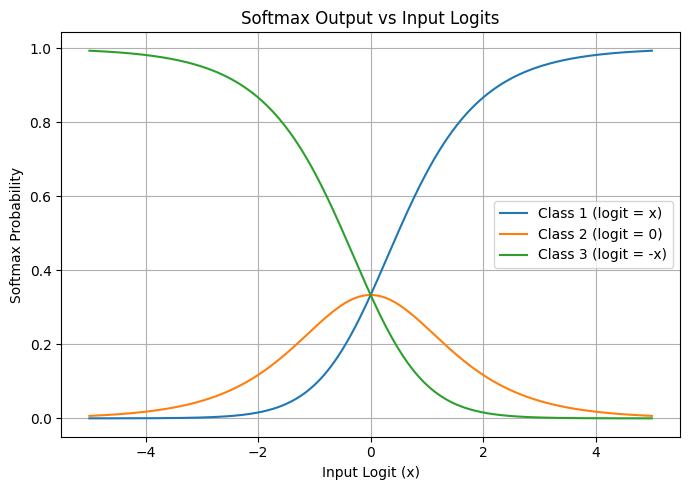

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of logit values for Class 1
x = np.linspace(-5, 5, 500)

# Simulate logits for 3 classes: class1 = x, class2 = 0, class3 = -x
logits = np.vstack([x, np.zeros_like(x), -x])

# Apply softmax
exp_logits = np.exp(logits)
softmax = exp_logits / np.sum(exp_logits, axis=0)

# Plot the softmax outputs
plt.figure(figsize=(7, 5))
plt.plot(x, softmax[0], label="Class 1 (logit = x)")
plt.plot(x, softmax[1], label="Class 2 (logit = 0)")
plt.plot(x, softmax[2], label="Class 3 (logit = -x)")
plt.title("Softmax Output vs Input Logits")
plt.xlabel("Input Logit (x)")
plt.ylabel("Softmax Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 📌 Why Apply Softmax?

#### 1. **Convert raw scores (logits) into probabilities**

* Model outputs (logits) are just arbitrary real numbers.
* Softmax turns them into values between **0 and 1** that **sum to 1**, making them interpretable as probabilities.

#### 2. **Focus on relative strength**

* Softmax emphasizes which class is more likely **relative to others**.
* A larger logit gets a **disproportionately higher** softmax score.

#### 3. **Required by cross-entropy math**

* Cross-entropy compares the predicted **probability** for the correct class.
* You can only calculate it after converting logits into probabilities using softmax:

  $$
  \text{CrossEntropy} = -\log(\text{softmax score of true class})
  $$

---

### ✅ PyTorch note:

If you use `nn.CrossEntropyLoss`, **you do NOT need to apply softmax manually**. It does `log_softmax + NLLLoss` internally in a numerically stable way.

---

Let me know if you want an example to visualize this!


### Cross Entropy Loss curve -log(p)

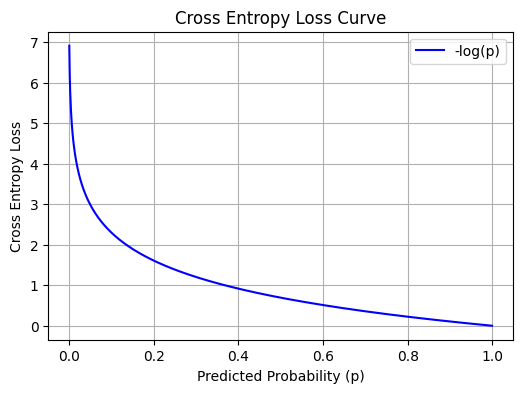

In [44]:
# Probability values close to 0–1
p = np.linspace(0.001, 0.999, 1000)
loss = -np.log(p)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(p, loss, label="-log(p)", color="blue")
plt.xlabel("Predicted Probability (p)")
plt.ylabel("Cross Entropy Loss")
plt.title("Cross Entropy Loss Curve")
plt.grid(True)
plt.legend()
plt.show()

### Natural logarithm curve log⁡(x):

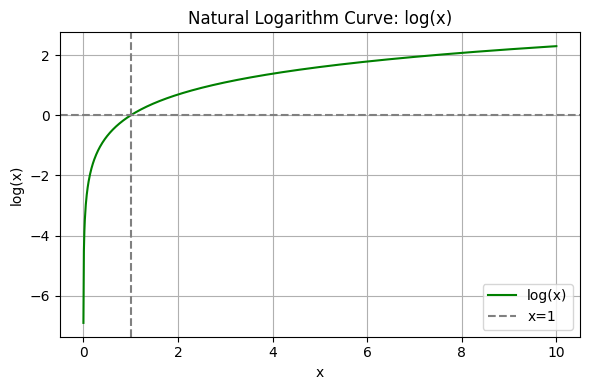

In [45]:
# x from 0.001 to 10
x = np.linspace(0.001, 10, 1000)
y = np.log(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y, color='green', label='log(x)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--', label='x=1')
plt.title("Natural Logarithm Curve: log(x)")
plt.xlabel("x")
plt.ylabel("log(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()